In [1]:
import h2o

from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
from __future__ import print_function

import findspark 
findspark.init()
from pyspark import SparkConf, SparkContext 
conf = SparkConf().setAppName("LogisticRegression").setMaster("spark://192.168.34.252:7077").set("spark.ui.port", "7077").set("spark.executor.memory", "1g").set("spark.driver.memory", "1g") 
#conf = SparkConf().setAppName("LogisticRegression").setMaster("local[*]").set("spark.ui.port", "7077").set("spark.executor.memory", "1g").set("spark.driver.memory", "1g") 
sc = SparkContext(conf=conf)

In [2]:
from pysparkling import *
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
h2oContext = H2OContext.getOrCreate(spark)
h2oContext.show()

Connecting to H2O server at http://192.168.34.189:54323... successful.


H2O cluster uptime:,16 secs
H2O cluster version:,3.16.0.4
H2O cluster version age:,3 months and 22 days !!!
H2O cluster name:,sparkling-water-cansu.yildiz_app-20180508095951-0255
H2O cluster total nodes:,2
H2O cluster free memory:,1.561 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://192.168.34.189:54323
H2O connection proxy:,None



Sparkling Water Context:
 * H2O name: sparkling-water-cansu.yildiz_app-20180508095951-0255
 * cluster size: 2
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (1,192.168.34.250,54321)
  (0,192.168.34.251,54321)
  ------------------------

  Open H2O Flow in browser: http://192.168.34.189:54323 (CMD + click in Mac OSX)

    

Sparkling Water Context:
 * H2O name: sparkling-water-cansu.yildiz_app-20180508095951-0255
 * cluster size: 2
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (1,192.168.34.250,54321)
  (0,192.168.34.251,54321)
  ------------------------

  Open H2O Flow in browser: http://192.168.34.189:54323 (CMD + click in Mac OSX)

    


In [3]:
print("import and parse data: ")
data=h2o.import_file(path="hdfs://192.168.34.252:9000/ozge/titanic_trainSet.csv")
test=h2o.import_file(path="hdfs://192.168.34.252:9000/ozge/titanic_testSet.csv")
testLabels=h2o.import_file(path="hdfs://192.168.34.252:9000/ozge/gender_submission.csv")
#data.describe()
labelArray=testLabels[1]
data.head()

import and parse data: 
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,nan,7.25,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,nan,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,nan,7.925,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,,S
6,0,3,"Moran, Mr. James",male,nan,0,0,330877,8.4583,,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.075,,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,,S
10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,,C


In [4]:
#split data as validation and train
r=data.runif(1234)
train=data[r<0.8]
validation=data[r>=0.8]

In [5]:
#Explore data with ----->  #data.types  #data.columns  #data.shape
#Then decide which columns(attributes) you are going to use
attributes=["Pclass","Sex","Age","SibSp","Parch","Ticket","Fare","Embarked"]  #predictors

for x in attributes:
    if data[x].isna().sum()>0:
        if data.types[x]=='enum':
            print("attribute:", x, "data type: ", data.types[x])
            mode_impute=data.impute(column=x,method="mode")
            print("after imputing: ", data[x].isna().sum())
        else:  
            #CHECK THE MISSING VALUES
            print("attribute:", x, "data type: ", data.types[x])
            print("before imputing: ", data[x].isna().sum())
            print("mean of column: " , data[x].mean())
            #IMPUTE NUMERIC MISSING VALUES
            mean_impute=data.impute(column=x,method="mean")     
            print("after imputing: ", data[x].isna().sum())
            print("mean of column: ", data[x].mean())

#make one column categorical with asfactor() function, making categorical is important for supervised algorithm
data['Survived']=data['Survived'].asfactor()
print(data['Survived'].levels())

attribute: Age data type:  real
before imputing:  177.0
mean of column:  [29.69911764705884]
after imputing:  0.0
mean of column:  [29.6991176470588]
attribute: Ticket data type:  int
before imputing:  230.0
mean of column:  [260318.5491679275]
after imputing:  0.0
mean of column:  [260318.5491679276]
attribute: Embarked data type:  enum
after imputing:  0.0
[['0', '1']]


In [5]:
#DESCRIBE THE ALGORITHM that will be used
logisticEstimator = H2OGeneralizedLinearEstimator(family="binomial",missing_values_handling="MeanImputation")
logisticEstimator.train(x=["Pclass","Sex","Age","SibSp","Parch","Ticket","Fare","Embarked"],y="Survived",training_frame=data,validation_frame=validation)
logisticEstimator.summary()



glm Model Build progress: |███████████████████████████████████████████████| 100%
GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,binomial,logit,"Elastic Net (alpha = 0.5, lambda = 3.29E-4 )",11,11,4,Key_Frame__hdfs___192_168_34_252_9000_ozge_titanic_trainSet.hex


In [6]:
logisticEstimator.confusion_matrix(train=True, valid=True)   #if you dont put parameters, it uses training data to get confusion matrix
#logisticEstimator.confusion_matrices(thresholds=[0.01,0.5,0.99],train=True, valid=True)
#dont use this function, when you use, it gives an error : type object 'H2OGeneralizedLinearEstimator' has no attribute 'confusion_matrices'

#print(logisticEstimator.logloss(train = True))
#logisticEstimator.accuracy(thresholds=None)
#print(logisticEstimator.logloss(validation = True))
#logisticEstimator.accuracy(thresholds=None, train=True, valid=False, xval=False)
#logisticEstimator.auc()
#! how to get precision?

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.578255348946: 


,0,1,Error,Rate
0,497.0,52.0,0.0947,(52.0/549.0)
1,110.0,232.0,0.3216,(110.0/342.0)
Total,607.0,284.0,0.1818,(162.0/891.0)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.611656100865: 


,0,1,Error,Rate
0,96.0,6.0,0.0588,(6.0/102.0)
1,24.0,53.0,0.3117,(24.0/77.0)
Total,120.0,59.0,0.1676,(30.0/179.0)


{u'train': , u'valid': }

In [8]:
pred_logRegr=logisticEstimator.predict(test)
print("logistic Regression Predictions: ")
print(pred_logRegr)
result=[]
result=pred_logRegr[0]

glm prediction progress: |████████████████████████████████████████████████| 100%
logistic Regression Predictions: 


predict,p0,p1
0,0.89437,0.10563
0,0.647539,0.352461
0,0.892659,0.107341
0,0.900708,0.0992924
0,0.492318,0.507682
0,0.840763,0.159237
1,0.32098,0.67902
0,0.80884,0.19116
1,0.217068,0.782932
0,0.929006,0.0709942


In [22]:
result[5,:]
#result_pd = result.as_data_frame()
#labelArray_pd = labelArray.as_data_frame()

#result_pd.

predict
0


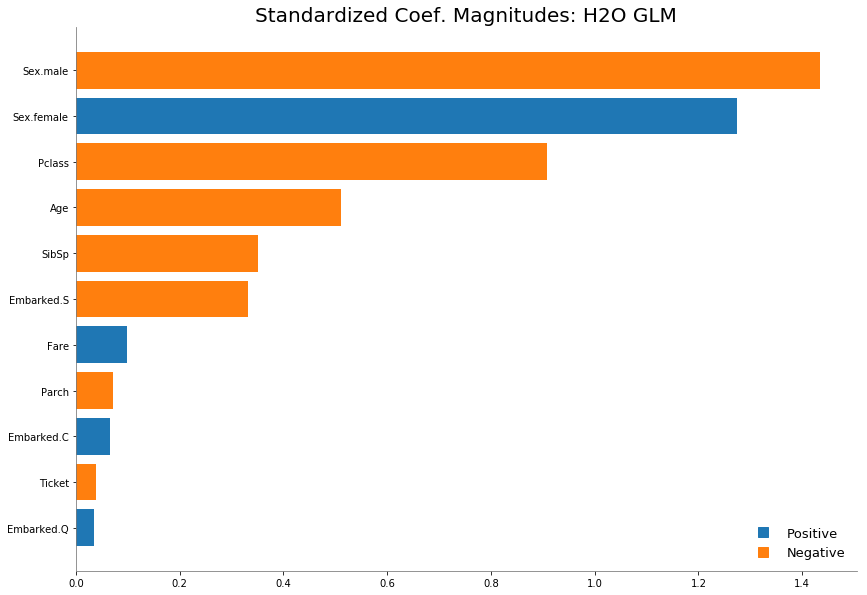

In [44]:
logisticEstimator.std_coef_plot()